
# OpenStreetMap with OSMnx

This example shows how to use OSMnx to download and model a street network
from OpenStreetMap, visualize centrality, then save the graph as a GeoPackage,
or GraphML file.

OSMnx is a Python package to download, model, analyze, and visualize street
networks and other geospatial features from OpenStreetMap. You can download
and model walking, driving, or biking networks with a single line of code then
easily analyze and visualize them. You can just as easily work with urban
amenities/points of interest, building footprints, transit stops, elevation
data, street orientations, speed/travel time, and routing.

See https://osmnx.readthedocs.io for the OSMnx documentation.
See https://github.com/gboeing/osmnx-examples for the OSMnx Examples gallery.


In [3]:
from pathlib import Path

import networkx as nx
import osmnx as ox
import matplotlib as plot
import sklearn

### Sample cell

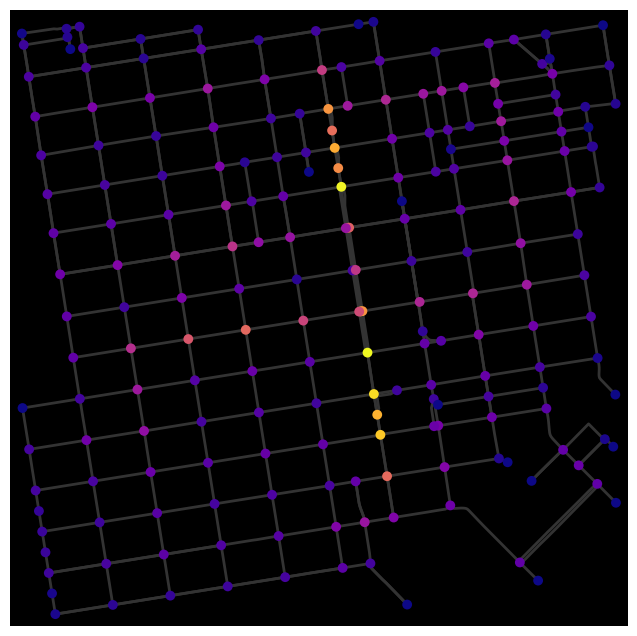

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib as plot

ox.settings.use_cache = True

# download street network data from OSM and construct a MultiDiGraph model
G = ox.graph.graph_from_point((37.79, -122.41), dist=750, network_type="drive")

# impute edge (driving) speeds and calculate edge travel times
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
G = ox.convert.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.convert.to_digraph(G, weight="travel_time")

# calculate node betweenness centrality, weighted by travel time
bc = nx.betweenness_centrality(D, weight="travel_time", normalized=True)
nx.set_node_attributes(G, values=bc, name="bc")

# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# save graph as a geopackage or graphml file
ox.io.save_graph_geopackage(G, filepath="./graph.gpkg")
ox.io.save_graphml(G, filepath="./graph.graphml")

### Generating & cleaning map of NYC to be downloaded and saved for future use

In [16]:
# Download a model of NYC and visualize it

G = ox.graph.graph_from_place("New York City, New York, USA", network_type="drive")
fig, ax = ox.plot.plot_graph(G)


KeyboardInterrupt: 

In [ ]:
# Add info about travel speed and time attributes

# impute speed on all edges missing data
G = ox.routing.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.routing.add_edge_travel_times(G)

In [ ]:
# Save graph as a geopackage
ox.io.save_graph_geopackage(G, filepath="./data/nyc_geopkg.gpkg")

# save/load graph as a graphml file: this is the best way to save your model
# for subsequent work later
filepath = "./data/nyc_graphml.graphml"
ox.io.save_graphml(G, filepath)
G = ox.io.load_graphml(filepath)

### Loading the graph and testing shortest paths algorithm 

In [ ]:
nyc_graph = ox.load_graphml("./data/nyc_graphml.graphml")

In [39]:
# define origin and destination by lat/lon
origin = (40.727704, -73.991533)
destination = (40.750219, -73.995057)

origin_node = ox.distance.nearest_nodes(nyc_graph, X=origin[1], Y=origin[0])
destination_node = ox.distance.nearest_nodes(nyc_graph, X=destination[1], Y=destination[0])

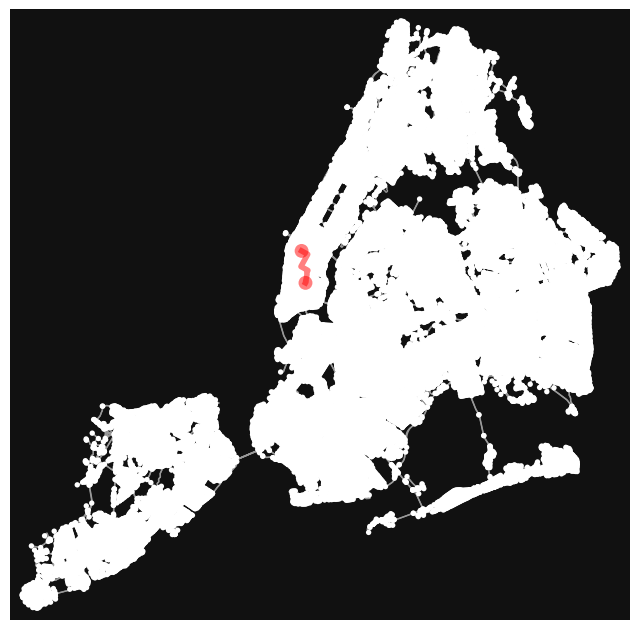

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [40]:
# find shortest route by travel time, can also do custom weight function
def weight(u, v, data):
    if data.get('blocked'):
        return float('inf')
    return data.get('travel_time', data.get('length', float('inf')))
# fall back to length if travel_time missing OR can default a speed
route = nx.shortest_path(nyc_graph, origin_node, destination_node, weight=weight)

# visualize
ox.plot_graph_route(nyc_graph, route)

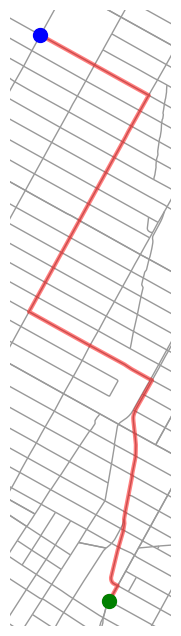

In [41]:
# Get node coordinates for the route
route_xs = [nyc_graph.nodes[n]['x'] for n in route]
route_ys = [nyc_graph.nodes[n]['y'] for n in route]
margin = 0.001

# -----------------------------
# 8. Plot route
# -----------------------------
fig, ax = ox.plot_graph_route(
    nyc_graph,
    route,
    route_color='red',
    route_linewidth=3,
    node_size=0,
    bgcolor='white',
    show=False,
    close=False
)

# Zoom to route
ax.set_xlim(min(route_xs) - margin, max(route_xs) + margin)
ax.set_ylim(min(route_ys) - margin, max(route_ys) + margin)

# Plot origin and destination markers
ax.scatter(nyc_graph.nodes[origin_node]['x'], nyc_graph.nodes[origin_node]['y'], c='green', s=100, zorder=5)
ax.scatter(nyc_graph.nodes[destination_node]['x'], nyc_graph.nodes[destination_node]['y'], c='blue', s=100, zorder=5)

plot.pyplot.show()

### Custom shortest path algorithm

### Graph statistics

In [42]:
# Look at a single edge
for u, v, k, data in nyc_graph.edges(keys=True, data=True):
    print(u, v, k, data)
    break

39076461 274283981 0 {'osmid': 25161349, 'highway': 'motorway', 'lanes': '2', 'maxspeed': '50 mph', 'name': 'Cross Island Parkway', 'oneway': True, 'ref': 'CI', 'reversed': False, 'length': 819.5016661477803, 'geometry': <LINESTRING (-73.795 40.786, -73.795 40.786, -73.794 40.786, -73.794 40.786,...>, 'speed_kph': 80.467, 'travel_time': 36.66355149479922}


In [24]:
# print graph node attributes

# pick any node (e.g., the first one)
first_node = list(nyc_graph.nodes)[0]
# print its attributes
print(nyc_graph.nodes[first_node])

{'y': 40.7863451, 'x': -73.7947484, 'highway': 'motorway_junction', 'ref': '33', 'street_count': 3}


In [ ]:
import itertools

# collect all unique node keys
node_keys = set(itertools.chain.from_iterable(d.keys() for _, d in nyc_graph.nodes(data=True)))
print("Node keys:", node_keys)

edge_keys = set(itertools.chain.from_iterable(d.keys() for _, _, d in nyc_graph.edges(data=True)))
print("Edge keys:", edge_keys)

Node keys: {'highway', 'y', 'street_count', 'railway', 'junction', 'x', 'ref'}
Edge keys: {'highway', 'tunnel', 'oneway', 'est_width', 'bridge', 'width', 'name', 'travel_time', 'geometry', 'maxspeed', 'junction', 'length', 'access', 'osmid', 'reversed', 'speed_kph', 'ref', 'lanes'}


In [ ]:
# Confirming the speeds in the graph are somewhat accurate

# see mean speed/time values by road type
edges = ox.convert.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",334.0,30.0,53.0
"['living_street', 'secondary']",68.8,40.2,6.2
"['motorway', 'motorway_link']",369.9,67.2,20.0
"['motorway', 'primary']",95.4,40.2,8.5
"['motorway_link', 'motorway']",907.0,62.1,52.4
"['motorway_link', 'primary']",220.5,36.2,22.6
"['motorway_link', 'residential']",627.5,58.8,38.4
"['motorway_link', 'secondary']",251.1,40.2,22.5
"['motorway_link', 'tertiary']",456.2,40.2,40.8


In [ ]:
# area of network in sq meters
G_proj = ox.projection.project_graph(G)
nodes_proj = ox.convert.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.union_all().convex_hull.area
graph_area_m

1197643362.06548

In [ ]:
# network stats
ox.stats.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)


{'n': 55248,
 'm': 139184,
 'k_avg': 5.038517231392992,
 'edge_length_total': 16123241.385322012,
 'edge_length_avg': 115.84119859554268,
 'streets_per_node_avg': 3.3227085143353605,
 'streets_per_node_counts': {0: 0,
  1: 3609,
  2: 294,
  3: 26645,
  4: 24111,
  5: 539,
  6: 48,
  7: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.0653236316246742,
  2: 0.005321459600347524,
  3: 0.4822799015348972,
  4: 0.4364139878366638,
  5: 0.009756009267303793,
  6: 0.0008688097306689834,
  7: 3.620040544454098e-05},
 'intersection_count': 51639,
 'street_length_total': 11173935.905144729,
 'street_segment_count': 91815,
 'street_length_avg': 121.70054898594705,
 'circuity_avg': 1.0205465477940838,
 'self_loop_proportion': 0.0008604258563415564,
 'clean_intersection_count': 43179,
 'node_density_km': 46.130594256973275,
 'intersection_density_km': 43.11717631110344,
 'edge_density_km': 13462.472966506108,
 'street_density_km': 9329.935988518262,
 'clean_intersection_density_km': 36.0533038